# Learning and Memorization

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Données

### 1) MNIST

In [2]:
mnistfile ="mnist.pkl.gz"

In [3]:
# Chargement des données
import dataset_loader
train_set, valid_set, test_set = dataset_loader.load_mnist(mnistfile)

label: 7


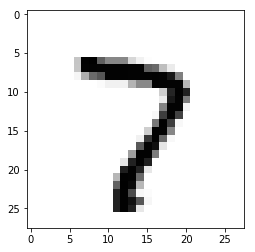

In [4]:
# Exemple d'image du MNIST
img_id = 42
plt.imshow(train_set[0][img_id].reshape(28,28) , cmap='Greys') 
print("label: " + str(train_set[1][img_id]))

In [5]:
# Création du nouveau label binaire : 0 si ancien label < 5 et 1 si >= 5
train_set_binarized_labels = (train_set[1] >= 5).astype(int)
valid_set_binarized_labels = (valid_set[1] >= 5).astype(int)

In [6]:
# Fonction servant à binariser les valeurs de chaque pixels d'une image
def binarise(img, s=0.5):
    nbr_pixels = len(img)
    L=np.zeros(nbr_pixels)
    for i in range(nbr_pixels) :
        if img[i]>s :
            L[i]=1
        else :
            L[i]=0
    return L

label binaire: 1


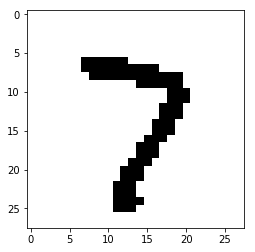

In [7]:
# Exemple d'image du MNIST binarisée avec label binaire
plt.imshow(binarise(train_set[0][img_id],s=0.5).reshape(28,28) , cmap='Greys') 
print("label binaire: " + str(train_set_binarized_labels[img_id]))

In [8]:
# Binarisation du dataset
for i in range (train_set[0].shape[0]):
    train_set[0][i]=binarise(train_set[0][i])

for i in range (valid_set[0].shape[0]):
    valid_set[0][i]=binarise(valid_set[0][i])

In [9]:
# Déclaration de X_train, y_train, X_test, y_test
X_train = train_set[0].astype(int)
y_train = train_set_binarized_labels

X_test = valid_set[0].astype(int)
y_test = valid_set_binarized_labels

## Implémentation du modèle

In [10]:
from sklearn.metrics import accuracy_score

class Memorization:
    
    """
    Initialise le modèle.
    """
    def __init__(self, layers, k):
        self.layers = layers # liste des couches de luts
        self.k = k # nombre d'entrée par lut
        self.list_luts = [] # liste des luts
        self.dict = self.init_dict()
        self.make_list_luts()

        self.list_link = [] # liste des liaisons entre luts
    
    """
    Crée la liste des liens entre les luts. 
        list_luts[i][j] correspond à l'ensemble des luts de la couche i qu'il faut ordonner 
        pour obtenir le jème lut de la couche i+1
    """
    def make_list_luts(self):
        self.list_luts = []

        L = []
        
        #génère la combinaison aléatoire de taille k pour chacune des couches et les ajoute dans une liste 'list_luts'
        for layer in range(1, len(self.layers)):
            L = []
            for i in range(self.layers[layer]):
                L.append(np.random.randint(0, self.layers[layer-1], self.k))
            self.list_luts.append(L)
            
    """
    Sert à initialiser un dictionnaire. 
    Le dictionnaire possède pour clés l'ensemble des nombres en binaire de 0 à 2**self.k-1
    Toutes les valeurs sont nulles
    """
    def init_dict(self):
        dict_ = {}
        for i in range(2**self.k):
            x = ("0"*self.k + str(bin(i))[2:])[-self.k:]
            dict_[x] = 0
        return dict_
    
    """
    Entraînement du modèle.
    Mets notamment à jour list_link :
        list_link[i][j] est un dictionnaire qui permet, pour le lut j de la couche i+1,
        de transformer la combinaison des k luts correspondans de la couche i en un nombre binaire (0 ou 1)
    """
    def fit(self, X_train, y_train, print_training_accuracy = False):
        #Display training accuracy for the first layer (layer 0)
        if print_training_accuracy:
                print("Layer = " + str(0) 
                      + " | Lut count = " + (str(self.layers[0]) + "    ")[:5]
                      + " | Training Accuracy = " + str(self.accuracy(X_train, y_train)))
                
        n = len(X_train)
        
        list_computed = [X_train] #initialise la liste des couches qui vont être calculées
        self.list_link = [] # liste des liaisons entre luts

        # Entraînement couche par couche
        for layer in range(1, len(self.layers)): #numero de la couche
            layer_luts = self.list_luts[layer - 1] #liste des luts de la couche précédente et de taille k (combinaison aléatoire)

            last_computed_layer = list_computed[-1] #récupère la dernière couche

            link = []
            next_computed_layer = [[0 for x in range(self.layers[layer])] for y in range(n)] #initialiste la couche suivante 
                                                                                             #(taille de la couche suivante * nombre d'exemples dans le dataset)
            
            for i in range(self.layers[layer]): #parcourt la taille de la couche pour chaque couche
                dict_positif = self.dict.copy() #init du dictionnaire stockant le nombre de valeurs positives
                dict_negatif = self.dict.copy() #init du dictionnaire stockant le nombre de valeurs négatives

                for j in range(n): #parcourt le nombre d'exemples dans le dataset
                    s = ""
                    for z in range(self.k): #parcourt la taille k pour chaque exemple
                        s += str(last_computed_layer[j][layer_luts[i][z]]) #donne la valeur binaire pour chaque exemple (j) grâce à la combinaison aléatoire des luts de la couche précédente 
                    next_computed_layer[j][i] = s #stocke la valeur binaire dans la nouvelle couche à la position (j=numero d'exemples, i=numero dans la taille de la couche)
                    dict_negatif[s] += (y_train[j] == 0).astype(int) #stocke dans le dict neg pour la clé binaire, le nombre de valeurs negatives dans le dataset
                    dict_positif[s] += (y_train[j] == 1).astype(int) #stocke dans le dict pos pour la clé binaire, le nombre de valeurs positive dans le dataset

                dict_ = self.dict.copy()
                
                #prédiction finale obtenu par la comparaison du nombre de valeurs positives par rapport aux nombres de valeurs négatives
                for l in dict_.keys():
                    if dict_positif[l] > dict_negatif[l]:
                        dict_[l] = 1
                    elif dict_positif[l] < dict_negatif[l]:
                        dict_[l] = 0
                    else :
                        dict_[l] = np.random.randint(2)

                #attribut la valeur finale pour la nouvelle couche à la position j(num exemple pour chaque exemple), i(num taille de la couche)
                for j in range(n): #reparcourt le nombre d'exemples dans le dataset
                    next_computed_layer[j][i] = dict_[next_computed_layer[j][i]]

                link.append(dict_) #rajoute le dict des valeurs prédites 'dict_' dans une liste 'link'

            list_computed.append(next_computed_layer) #rajoute la nouvelle couche dans la liste 'list_computed'
            self.list_link.append(link) #rajoute la liste 'link' dans la liste générale 'list_link'
            
            if print_training_accuracy:
                print("Layer = " + str(layer) 
                      + " | Lut count = " + (str(self.layers[layer]) + "    ")[:5] 
                      + " | Training Accuracy = " + str(self.accuracy(X_train, y_train)))
    
    """
    Prediction de la classe pour une entrée x.
    """
    def one_prediction(self, x):   
        list_computed = [x]

        # Calcul couche par couche
        for layer in range(len(self.list_link)):
            layer_luts = self.list_luts[layer]
            link = self.list_link[layer]
            last_computed_layer = list_computed[-1]

            next_computed_layer = []
            for i in range(len(layer_luts)):
                s = ""
                for z in range(self.k):
                    s += str(last_computed_layer[layer_luts[i][z]])
                next_computed_layer.append(link[i][s])
            list_computed.append(next_computed_layer)
        
        # Somme du nombre de 1 sur l'ensemble des luts de la dernière couche
        resu = 0
        for i in range(len(self.list_luts[len(self.list_link) - 1])):
            resu += list_computed[-1][i]
        
        # Retourne 1 si il y a plus de 1 que de 0 sur l'ensemble des luts de la dernière couche (0 sinon)
        return int(resu > len(self.list_luts[len(self.list_link) - 1]) / 2)
    
    """
    Prediction de la classe pour le vecteur X. 
    """
    def predict(self, X):
        y = []
        for x in X:
            y.append(self.one_prediction(x))
        return np.array(y)
    
    """
    Calcul de la précision du modèle.
    """
    def accuracy(self, X, y):
        return accuracy_score(self.predict(X), y)

## Expérimentations

### Expérimentation n°1

L'objectif de l'expérience 1 est d'entraîner un modèle de réseau de look up tables sur le dataset mnist binarisé.

In [11]:
layers = [784, 1024, 1024, 1024, 1024, 1024, 1] 

In [12]:
k=8

In [13]:
model = Memorization(layers, k)

In [82]:
model.fit(X_train, y_train, print_training_accuracy = True)

Layer = 0 | Lut count = 784   | Training Accuracy = 0.51076
Layer = 1 | Lut count = 1024  | Training Accuracy = 0.78768
Layer = 2 | Lut count = 1024  | Training Accuracy = 0.84706
Layer = 3 | Lut count = 1024  | Training Accuracy = 0.86198
Layer = 4 | Lut count = 1024  | Training Accuracy = 0.87266
Layer = 5 | Lut count = 1024  | Training Accuracy = 0.88226
Layer = 6 | Lut count = 1     | Training Accuracy = 0.88486


### Expérimentation n°2

L'expérience 2 consiste à étudier l'apprentissage du modèle lorsque la taille de combinaison de lut prise dans le modèle (correspondant à "k") varie.
Pour l'expérience, k varie de 2 à 16.
On conserve la même architecture de réseau.

In [83]:
for k in [2,4,6,8,10,12,14,16]:
    model = Memorization(layers, k)
    model.fit(X_train, y_train)
    print("k = " + (str(k) + "  ")[:3]
          + " | Training Accuracy = " + (str(model.accuracy(X_train, y_train)) + "   ")[:5] 
          + " | Test Accuracy = " + str(model.accuracy(X_test, y_test)))

k = 2   | Training Accuracy = 0.621 | Test Accuracy = 0.6217
k = 4   | Training Accuracy = 0.806 | Test Accuracy = 0.8123
k = 6   | Training Accuracy = 0.843 | Test Accuracy = 0.8463
k = 8   | Training Accuracy = 0.889 | Test Accuracy = 0.8748
k = 10  | Training Accuracy = 0.945 | Test Accuracy = 0.8928
k = 12  | Training Accuracy = 0.989 | Test Accuracy = 0.8886
k = 14  | Training Accuracy = 0.999 | Test Accuracy = 0.8062
k = 16  | Training Accuracy = 0.999 | Test Accuracy = 0.6382


### Expérimentation n°3

L'objectif consiste à étudier l'apprentissage du modèle en fonction du type de données : réel ou bien aléatoire. Dans l'expérience, on labelise donc aléatoirement nos images avec des 0 ou 1.

In [16]:
y_train_random = np.array([np.random.randint(2) for i in range(len(y_train))])
y_test_random = np.array([np.random.randint(2) for i in range(len(y_test))])

In [17]:
for k in [2,4,6,8,10,12,14,16]:
    model = Memorization(layers, k)
    model.fit(X_train, y_train_random)
    print("k = " + (str(k) + "  ")[:3]
          + " | Training Accuracy = " + (str(model.accuracy(X_train, y_train_random)) + "   ")[:5] 
          + " | Test Accuracy = " + str(model.accuracy(X_test, y_test_random)))

k = 2   | Training Accuracy = 0.533 | Test Accuracy = 0.504
k = 4   | Training Accuracy = 0.566 | Test Accuracy = 0.513
k = 6   | Training Accuracy = 0.657 | Test Accuracy = 0.511
k = 8   | Training Accuracy = 0.766 | Test Accuracy = 0.493
k = 10  | Training Accuracy = 0.938 | Test Accuracy = 0.471
k = 12  | Training Accuracy = 0.987 | Test Accuracy = 0.508
k = 14  | Training Accuracy = 0.998 | Test Accuracy = 0.512
k = 16  | Training Accuracy = 0.998 | Test Accuracy = 0.508


### Expérience n°4

L'objectif de cette expérience est de comparer le modèle de mémorisation avec des méthodes standards de machine learning.

In [13]:
list_results = []

In [14]:
# Test du modèle : 5-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn_5 = KNeighborsClassifier(n_neighbors = 5)
knn_5.fit(X_train, y_train)
knn_5_train_accuracy = accuracy_score(knn_5.predict(X_train), y_train)
knn_5_test_accuracy = accuracy_score(knn_5.predict(X_test), y_test)

list_results.append(("5-Nearest Neighbors", knn_5_train_accuracy, knn_5_test_accuracy))

In [15]:
# Test du modèle : 1-Nearest Neighbors
knn_1 = KNeighborsClassifier(n_neighbors = 1)
knn_1.fit(X_train, y_train)
knn_1_train_accuracy = accuracy_score(knn_1.predict(X_train), y_train)
knn_1_test_accuracy = accuracy_score(knn_1.predict(X_test), y_test)

list_results.append(("1-Nearest Neighbors", knn_1_train_accuracy, knn_1_test_accuracy))

In [21]:
# Test du modèle : Random Forest (10 Trees)
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_train_accuracy = accuracy_score(rf.predict(X_train), y_train)
rf_test_accuracy = accuracy_score(rf.predict(X_test), y_test)

list_results.append(("Random Forest (10 Trees)", rf_train_accuracy, rf_test_accuracy))

In [17]:
# Test du modèle : Memorization
k=12
memo = Memorization(layers, k)
memo.fit(X_train, y_train)
memo_train_accuracy = accuracy_score(memo.predict(X_train), y_train)
memo_test_accuracy = accuracy_score(memo.predict(X_test), y_test)

list_results.append(("Memorization", memo_train_accuracy, memo_test_accuracy))

In [23]:
# Test du modèle : Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_train_accuracy = accuracy_score(lr.predict(X_train), y_train)
lr_test_accuracy = accuracy_score(lr.predict(X_test), y_test)

list_results.append(("Logistic Regression", lr_train_accuracy, lr_test_accuracy))

In [19]:
# Test du modèle : Naïve Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
nb_train_accuracy = accuracy_score(nb.predict(X_train), y_train)
nb_test_accuracy = accuracy_score(nb.predict(X_test), y_test)

list_results.append(("Naïve Bayes", nb_train_accuracy, nb_test_accuracy))

In [20]:
# Test du modèle : Random Guess
random_guess = lambda x : np.random.randint(2)
rg_train_accuracy = accuracy_score([random_guess(x) for x in X_train], y_train)
rg_test_accuracy = accuracy_score([random_guess(x) for x in X_test], y_test)


list_results.append(("Random Guess", rg_train_accuracy, rg_test_accuracy))

In [21]:
# Comparaison des modèles

for name, train_acc, test_acc in list_results:
    print((str(name) + "             ")[:24] 
          + " | Training Accuracy = " + (str(train_acc) + "   ")[:6]
          + " | Test Accuracy = " + str(test_acc))

5-Nearest Neighbors      | Training Accuracy = 0.9841 | Test Accuracy = 0.98
1-Nearest Neighbors      | Training Accuracy = 1.0    | Test Accuracy = 0.9754
Random Forest (10 Trees) | Training Accuracy = 0.9988 | Test Accuracy = 0.961
Memorization             | Training Accuracy = 0.8816 | Test Accuracy = 0.8699
Logistic Regression      | Training Accuracy = 0.8652 | Test Accuracy = 0.8721
Naïve Bayes              | Training Accuracy = 0.6737 | Test Accuracy = 0.6802
Random Guess             | Training Accuracy = 0.4978 | Test Accuracy = 0.4939


### Expérience n°5

L'objectif de cette expérience est d'appliquer le principe de mémorisation sur la tâche de séparation du i-ème digit de MNIST avec le j-ème digit.
On a 10 digits différents (0 à 9) et des paires de digits. Ce qui revient à faire 2 parmi n expériences (=45).

In [4]:
mnistfile ="mnist.pkl.gz"

In [5]:
# Chargement des données
import dataset_loader
train_set, valid_set, test_set = dataset_loader.load_mnist(mnistfile)

In [6]:
# Binarisation du dataset
for i in range (train_set[0].shape[0]):
    train_set[0][i]=binarise(train_set[0][i])

for i in range (valid_set[0].shape[0]):
    valid_set[0][i]=binarise(valid_set[0][i])

In [22]:
#création du dataset du digit i et du digit j.
def create_pairwise_dataset(digit_i, digit_j, train_set, valid_set):
    """train set"""
    #train set (digit i et digit j)
    digit_i_train_idx = np.where(train_set[1]==digit_i)
    digit_j_train_idx = np.where(train_set[1]==digit_j)
    pairwise_train_idx = np.concatenate((digit_i_train_idx, digit_j_train_idx), axis=1)
    
    train_X, train_y = train_set[0][tuple(pairwise_train_idx)].astype(int), train_set[1][tuple(pairwise_train_idx)]
    
    #transform labels of digit i and digit j into 1 and 0
    #digit_i = 1 by default
    train_y = (train_y == digit_i).astype(int)
    
    #shuffle
    train_perm = np.random.permutation(train_X.shape[0])
    new_train_set = [train_X[train_perm,:], train_y[train_perm]]
    
    """test set"""
    #test set (digit i et digit j)
    digit_i_val_idx = np.where(valid_set[1]==digit_i)
    digit_j_val_idx = np.where(valid_set[1]==digit_j)
    pairwise_val_idx = np.concatenate((digit_i_val_idx, digit_j_val_idx), axis=1)
    
    test_X, test_y = valid_set[0][tuple(pairwise_val_idx)].astype(int), valid_set[1][tuple(pairwise_val_idx)]

    #transform labels of digit i and digit j into 1 and 0
    #digit_i = 1 by default
    test_y = (test_y == digit_i).astype(int)
    
    
    #shuffle
    test_perm = np.random.permutation(test_X.shape[0])
    new_test_set = [test_X[test_perm,:], test_y[test_perm]]
    
    return new_train_set, new_test_set

In [9]:
pairwise_matrix=np.identity(10)

k_list=[]
train_acc_list=[]
test_acc_list=[]
        
for digit_i in range(pairwise_matrix.shape[0]):
    for digit_j in range(pairwise_matrix.shape[1]):
        if pairwise_matrix[digit_i, digit_j]==0:
            new_train_set, new_test_set = create_pairwise_dataset(digit_i, digit_j, train_set, valid_set)
            X_train, y_train = new_train_set[0], new_train_set[1]
            X_test, y_test = new_test_set[0], new_test_set[1]
            
            #uptade conditions
            pairwise_matrix[digit_i, digit_j]=1
            pairwise_matrix[digit_j, digit_i]=1

            #calculate for each dataset and each k, training and test accuracy
            print('i-th digit: {a}, j-th digit: {b}'.format(a=digit_i, b=digit_j))
            for k in [2,4,6,8,10,12,14,16]:
                model = Memorization(layers, k)
                model.fit(X_train, y_train)
                
                train_acc = model.accuracy(X_train, y_train)
                test_acc = model.accuracy(X_test, y_test)
                
                k_list.append(k)
                train_acc_list.append(train_acc)
                test_acc_list.append(test_acc)
                
                print("k = " + (str(k) + "  ")[:3]
          + " | Training Accuracy = " + (str(train_acc) + "   ")[:5] 
          + " | Test Accuracy = " + str(test_acc)[:5])

i-th digit: 0, j-th digit: 1
k = 2   | Training Accuracy = 0.976 | Test Accuracy = 0.979
k = 4   | Training Accuracy = 0.998 | Test Accuracy = 0.998
k = 6   | Training Accuracy = 0.999 | Test Accuracy = 0.996
k = 8   | Training Accuracy = 1.0   | Test Accuracy = 0.981
k = 10  | Training Accuracy = 1.0   | Test Accuracy = 0.945
k = 12  | Training Accuracy = 1.0   | Test Accuracy = 0.841
k = 14  | Training Accuracy = 1.0   | Test Accuracy = 0.769
k = 16  | Training Accuracy = 1.0   | Test Accuracy = 0.726
i-th digit: 0, j-th digit: 2
k = 2   | Training Accuracy = 0.836 | Test Accuracy = 0.859
k = 4   | Training Accuracy = 0.979 | Test Accuracy = 0.980
k = 6   | Training Accuracy = 0.992 | Test Accuracy = 0.985
k = 8   | Training Accuracy = 0.999 | Test Accuracy = 0.978
k = 10  | Training Accuracy = 1.0   | Test Accuracy = 0.935
k = 12  | Training Accuracy = 1.0   | Test Accuracy = 0.783
k = 14  | Training Accuracy = 1.0   | Test Accuracy = 0.642
k = 16  | Training Accuracy = 1.0   | Test

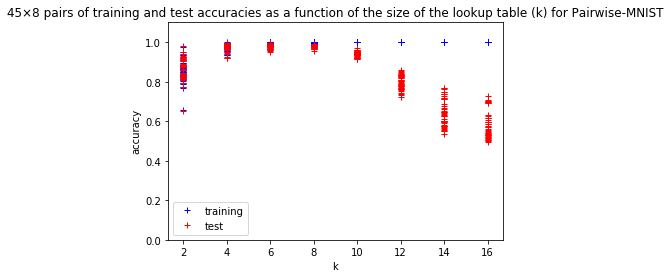

In [10]:
#display graph
plt.plot(k_list, train_acc_list, 'b+', label='training')
plt.plot(k_list,test_acc_list, 'r+', label='test')
plt.title('45×8 pairs of training and test accuracies as a function of the size of the lookup table (k) for Pairwise-MNIST')
plt.legend()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.ylim(0,1.1)
plt.show()

### Expérience n°6

L'objectif de l'expérience est de reproduire l'expérience 5 en gardant k=2 et en faisant varier le nombre de couches (de 2^0 à 2^5). Chaque couche à 1024 luts.

In [8]:
pairwise_matrix=np.identity(10)

d_list=[]
train_acc_list=[]
test_acc_list=[]
        
for digit_i in range(pairwise_matrix.shape[0]):
    for digit_j in range(pairwise_matrix.shape[1]):
        if pairwise_matrix[digit_i, digit_j]==0:
            new_train_set, new_test_set = create_pairwise_dataset(digit_i, digit_j, train_set, valid_set)
            X_train, y_train = new_train_set[0], new_train_set[1]
            X_test, y_test = new_test_set[0], new_test_set[1]
            
            #uptade conditions
            pairwise_matrix[digit_i, digit_j]=1
            pairwise_matrix[digit_j, digit_i]=1

            #calculate for each dataset and each k, training and test accuracy
            print('i-th digit: {a}, j-th digit: {b}'.format(a=digit_i, b=digit_j))
            for d in [0,1,2,3,4,5]:
                
                #create layers
                #layers = [784, 1024, 1024, 1024, 1024, 1024, 1] 
                layers = [784] #init
                layers+=(d*[1024]) #should be 1024
                layers.append(1)
                
                #train model
                model = Memorization(layers, k=2)
                model.fit(X_train, y_train)
                
                #predict and calculate accuracy
                train_acc = model.accuracy(X_train, y_train)
                test_acc = model.accuracy(X_test, y_test)
                
                #store data
                d_list.append(d)
                train_acc_list.append(train_acc)
                test_acc_list.append(test_acc)
                
                print("d = " + (str(d) + "  ")[:3]
          + " | Training Accuracy = " + (str(train_acc) + "   ")[:5] 
          + " | Test Accuracy = " + str(test_acc)[:5])

i-th digit: 0, j-th digit: 1
d = 0   | Training Accuracy = 0.535 | Test Accuracy = 0.517
d = 1   | Training Accuracy = 0.535 | Test Accuracy = 0.517
d = 2   | Training Accuracy = 0.716 | Test Accuracy = 0.697
d = 3   | Training Accuracy = 0.902 | Test Accuracy = 0.905
d = 4   | Training Accuracy = 0.953 | Test Accuracy = 0.946
d = 5   | Training Accuracy = 0.979 | Test Accuracy = 0.983
i-th digit: 0, j-th digit: 2
d = 0   | Training Accuracy = 0.516 | Test Accuracy = 0.485
d = 1   | Training Accuracy = 0.745 | Test Accuracy = 0.741
d = 2   | Training Accuracy = 0.743 | Test Accuracy = 0.733
d = 3   | Training Accuracy = 0.737 | Test Accuracy = 0.716
d = 4   | Training Accuracy = 0.846 | Test Accuracy = 0.862
d = 5   | Training Accuracy = 0.854 | Test Accuracy = 0.865
i-th digit: 0, j-th digit: 3
d = 0   | Training Accuracy = 0.558 | Test Accuracy = 0.568
d = 1   | Training Accuracy = 0.685 | Test Accuracy = 0.701
d = 2   | Training Accuracy = 0.877 | Test Accuracy = 0.890
d = 3   | Tra

In [9]:
diff_acc_list = np.abs(np.array(test_acc_list)-np.array(train_acc_list))

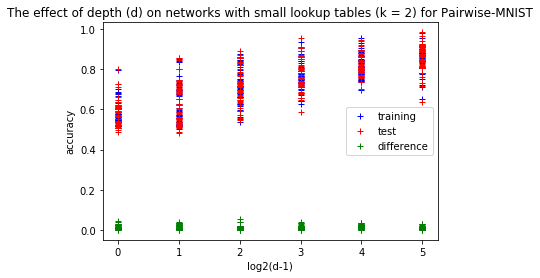

In [10]:
#display graph
plt.plot(d_list, train_acc_list, 'b+', label='training')
plt.plot(d_list, test_acc_list, 'r+', label='test')
plt.plot(d_list, diff_acc_list, 'g+', label='difference')
plt.title('The effect of depth (d) on networks with small lookup tables (k = 2) for Pairwise-MNIST')
plt.legend()
plt.xlabel('log2(d-1)')
plt.ylabel('accuracy')
plt.show()

### Expérience n°7

L'objectif de l'expérience est de reproduire le modèle de mémorisation sur le dataset CIFAR-10

**DATA**

In [67]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [68]:
X_train = X_train/255
X_test = X_test/255

X_train = X_train.astype(int)
X_test = X_test.astype(int)

X_train = X_train.reshape(-1,32*32*3)
X_test = X_test.reshape(-1,32*32*3)

In [69]:
# Fonction servant à binariser les valeurs de chaque pixels d'une image
def binarise(img, s=0.5):
    nbr_pixels = len(img)
    L=np.zeros(nbr_pixels)
    for i in range(nbr_pixels) :
        if img[i]>s :
            L[i]=1
        else :
            L[i]=0
    return L

In [70]:
# Binarisation du dataset
for i in range (X_train.shape[0]):
    X_train[i]=binarise(X_train[i])

for i in range (X_test.shape[0]):
    X_test[i]=binarise(X_test[i])

In [45]:
y_train = (y_train >= 5).astype(int)
y_test = (y_test >= 5).astype(int)

In [71]:
y_train = y_train.reshape(y_train.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)

In [29]:
list_results = []

In [30]:
# Test du modèle : CONV NET

X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

#should have images in form (32, 32, 3)
from keras import models
from keras import layers
from keras import optimizers

cnn = models.Sequential()
cnn.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(16, activation = 'relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
rms=optimizers.RMSprop()
cnn.compile(loss='binary_crossentropy',optimizer=rms,metrics=['acc'])

print('Training...')
history = cnn.fit(X_train, y_train, epochs=3, batch_size=32)

print('Evaluating...')
cnn_train_acc = history.history['acc']
_, cnn_test_acc = cnn.evaluate(X_test, y_test)
list_results.append(("CONV NET", cnn_train_acc[-1], cnn_test_acc))

X_train = X_train.reshape(-1,32*32*3)
X_test = X_test.reshape(-1,32*32*3)

Training...
Epoch 1/3
50000/50000 [==============================] - 9s 189us/step - loss: 0.6873 - acc: 0.5332
Epoch 2/3
50000/50000 [==============================] - 6s 129us/step - loss: 0.6822 - acc: 0.5440
Epoch 3/3
50000/50000 [==============================] - 6s 130us/step - loss: 0.6780 - acc: 0.5483
Evaluating...
10000/10000 [==============================] - 1s 64us/step


In [31]:
# Test du modèle : Random Forest (300 Trees)
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 300)
rf.fit(X_train, y_train)
rf_train_accuracy = accuracy_score(rf.predict(X_train), y_train)
rf_test_accuracy = accuracy_score(rf.predict(X_test), y_test)

list_results.append(("Random Forest (300 Trees)", rf_train_accuracy, rf_test_accuracy))

In [32]:
# Test du modèle : 5-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn_5 = KNeighborsClassifier(n_neighbors = 5)
knn_5.fit(X_train, y_train)
knn_5_train_accuracy = accuracy_score(knn_5.predict(X_train), y_train)
knn_5_test_accuracy = accuracy_score(knn_5.predict(X_test), y_test)

list_results.append(("5-Nearest Neighbors", knn_5_train_accuracy, knn_5_test_accuracy))

In [33]:
# Test du modèle : 1-Nearest Neighbors
knn_1 = KNeighborsClassifier(n_neighbors = 1)
knn_1.fit(X_train, y_train)
knn_1_train_accuracy = accuracy_score(knn_1.predict(X_train), y_train)
knn_1_test_accuracy = accuracy_score(knn_1.predict(X_test), y_test)

list_results.append(("1-Nearest Neighbors", knn_1_train_accuracy, knn_1_test_accuracy))

In [34]:
# Test du modèle : Memorization
#5 hidden layers of 1024 luts
#k=10
layers=[784, 1024, 1024, 1024, 1024, 1024, 1]
memo = Memorization(layers, k=10)
memo.fit(X_train, y_train)
memo_train_accuracy = accuracy_score(memo.predict(X_train), y_train)
memo_test_accuracy = accuracy_score(memo.predict(X_test), y_test)

list_results.append(("Memorization", memo_train_accuracy, memo_test_accuracy))

In [35]:
# Test du modèle : Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
lr_train_accuracy = accuracy_score(lr.predict(X_train), y_train)
lr_test_accuracy = accuracy_score(lr.predict(X_test), y_test)

list_results.append(("Logistic Regression", lr_train_accuracy, lr_test_accuracy))

In [36]:
# Test du modèle : Naïve Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
nb_train_accuracy = accuracy_score(nb.predict(X_train), y_train)
nb_test_accuracy = accuracy_score(nb.predict(X_test), y_test)

list_results.append(("Naïve Bayes", nb_train_accuracy, nb_test_accuracy))

In [37]:
# Test du modèle : Random Guess
random_guess = lambda x : np.random.randint(2)
rg_train_accuracy = accuracy_score([random_guess(x) for x in X_train], y_train)
rg_test_accuracy = accuracy_score([random_guess(x) for x in X_test], y_test)


list_results.append(("Random Guess", rg_train_accuracy, rg_test_accuracy))

In [42]:
# Comparaison des modèles

for name, train_acc, test_acc in list_results:
    print((str(name) + "                 ")[:25] 
          + " | Training Accuracy = " + (str(train_acc) + "   ")[:6]
          + " | Test Accuracy = " + str(test_acc))

CONV NET                  | Training Accuracy = 0.69   | Test Accuracy = 0.5935
Random Forest (300 Trees) | Training Accuracy = 1.0    | Test Accuracy = 0.603
5-Nearest Neighbors       | Training Accuracy = 0.702  | Test Accuracy = 0.5745
1-Nearest Neighbors       | Training Accuracy = 1.0    | Test Accuracy = 0.575
Memorization              | Training Accuracy = 0.943  | Test Accuracy = 0.5255
Logistic Regression       | Training Accuracy = 1.0    | Test Accuracy = 0.5345
Naïve Bayes               | Training Accuracy = 0.554  | Test Accuracy = 0.547
Random Guess              | Training Accuracy = 0.5125 | Test Accuracy = 0.496


### Expérience n°8

L'objectif de l'expérience est de garder la même architecture de réseau de l'expérience 7 et de l'appliquer à la tâche de séparation des catégories 1 à 1 (similaire à l'expérience 5).

In [72]:
train_set = [X_train, y_train]
test_set = [X_test, y_test]

In [78]:
pairwise_matrix=np.identity(10)

k_list=[]
train_acc_list=[]
test_acc_list=[]
        
for class_i in range(pairwise_matrix.shape[0]):
    for class_j in range(pairwise_matrix.shape[1]):
        if pairwise_matrix[class_i, class_j]==0:
            new_train_set, new_test_set = create_pairwise_dataset(class_i, class_j, train_set, test_set)
            X_train, y_train = new_train_set[0], new_train_set[1]
            X_test, y_test = new_test_set[0], new_test_set[1]
            
            #uptade conditions
            pairwise_matrix[class_i, class_j]=1
            pairwise_matrix[class_j, class_i]=1

            #calculate for each dataset and each k, training and test accuracy
            print('class i: {a}, class j: {b}'.format(a=class_i, b=class_j))
            
            k=10
            layers=[784, 1024, 1024, 1024, 1024, 1024, 1]
            model = Memorization(layers, k)
            model.fit(X_train, y_train)
                
            train_acc = model.accuracy(X_train, y_train)
            test_acc = model.accuracy(X_test, y_test)
                
            k_list.append(k)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
                
            print("k = " + (str(k) + "  ")[:3]
          + " | Training Accuracy = " + (str(train_acc) + "   ")[:5] 
          + " | Test Accuracy = " + str(test_acc)[:5])

class i: 0, class j: 1
k = 10  | Training Accuracy = 0.619 | Test Accuracy = 0.539
class i: 0, class j: 2
k = 10  | Training Accuracy = 0.588 | Test Accuracy = 0.527
class i: 0, class j: 3
k = 10  | Training Accuracy = 0.573 | Test Accuracy = 0.514
class i: 0, class j: 4
k = 10  | Training Accuracy = 0.590 | Test Accuracy = 0.522
class i: 0, class j: 5
k = 10  | Training Accuracy = 0.582 | Test Accuracy = 0.519
class i: 0, class j: 6
k = 10  | Training Accuracy = 0.589 | Test Accuracy = 0.521
class i: 0, class j: 7
k = 10  | Training Accuracy = 0.620 | Test Accuracy = 0.539
class i: 0, class j: 8
k = 10  | Training Accuracy = 0.569 | Test Accuracy = 0.508
class i: 0, class j: 9
k = 10  | Training Accuracy = 0.712 | Test Accuracy = 0.604
class i: 1, class j: 2
k = 10  | Training Accuracy = 0.632 | Test Accuracy = 0.579
class i: 1, class j: 3
k = 10  | Training Accuracy = 0.627 | Test Accuracy = 0.551
class i: 1, class j: 4
k = 10  | Training Accuracy = 0.634 | Test Accuracy = 0.576
clas

### Expérience n°9

L'objectif de l'expérience est d'apprendre une forme, ici un cercle à partir de points dont les positions sont encodés sous forme de nombre à 10 bits.

- encoder chaque point de position (x,y) en un nombre de 10 bits. 
- par exemple A=(-1,1) en point A=(0010111111,0001010101)

In [2]:
#creation de la condition du cercle pour attribuer la couleur du point
def circle_cond(x, y):
    if x**2 + y**2 <= (1.6**2):
        return 1
    else:
        return 0

In [3]:
#transformation du nombre de 10 bits en localisation (x,y)
def transform_X_to_coord(X, dict_loc):
    x=[]
    y=[]
    for i in range(X.shape[0]):
        s=""
        for j in range(X.shape[1]):
            s+=str(X[i][j])
        coord = dict_loc[s]
        x.append(coord[0])
        y.append(coord[1])
    return x, y
        

In [8]:
#création du dataset de données X : nombres de 10 bits pour position x, y (taille 20) et Y (nombre binaire (1 ou 0) pour restituer la bonne couleur)
import random
random.seed(42)

x_set = []
y_set = []
#Create a 100x100 grid
grid_space = np.linspace(-2.0, 2.0, 100)

grid=np.zeros((100,100))
dict_loc = {}

#dictionnaire qui stocke pour chaque nombre de 10 bits sa position
list_bin=[]
for i in range(100):
    list_bin.append(("0"*10 + str(bin(i))[2:])[-10:])

nb_exemples = 10000 #genere 100*100 points
for ex in range(nb_exemples):
    x_idx = random.randint(0,99)
    y_idx = random.randint(0,99)
    if grid[x_idx][y_idx]==0:
        p_x = np.array([int(list_bin[x_idx][e]) for e in range(10)])
        p_y = np.array([int(list_bin[y_idx][e]) for e in range(10)])
        encoded_point = np.concatenate((p_x, p_y), axis=0)
        x_set.append(encoded_point)
        x = grid_space[x_idx]
        y = grid_space[y_idx]
        str_encoded_point=""
        for k in range(20):
            str_encoded_point+=str(encoded_point[k])
        dict_loc[str_encoded_point]=[x, y]
        true_y = circle_cond(x, y)
    
        y_set.append(true_y)
        
        #update
        grid[x_idx][y_idx]==1
    
x_set = np.array(x_set, dtype=int)
y_set =np.array(y_set, dtype=int)

In [9]:
#séparation du dataset : train et test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_set, y_set, test_size=0.5, random_state=42)

In [10]:
#entrainement du modèle et apprentissage de la forme cercle
layers = [20]
layers += (32*[2048])
layers.append(1)

train_preds = {}
test_preds = {}

k_list = [2, 6, 10]

for k in k_list:
    #train model
    model = Memorization(layers, k)
    model.fit(X_train, y_train)
    
    #predict and calculate accuracy
    train_acc = model.accuracy(X_train, y_train)
    test_acc = model.accuracy(X_test, y_test)

    #store data
    train_y_pred = model.predict(X_train)
    test_y_pred = model.predict(X_test)
    train_preds[k] = train_y_pred
    test_preds[k] = test_y_pred

    print("k = " + (str(k) + "  ")[:3]
        + " | Training Accuracy = " + (str(train_acc) + "   ")[:5] 
        + " | Test Accuracy = " + str(test_acc)[:5])

k = 2   | Training Accuracy = 0.900 | Test Accuracy = 0.899
k = 6   | Training Accuracy = 0.995 | Test Accuracy = 0.956
k = 10  | Training Accuracy = 1.0   | Test Accuracy = 0.837


In [4]:
#affichage du cercle
def plot_circle(X, y, ax, title='title'):
    
    x_g, y_g = transform_X_to_coord(X[tuple(np.where(y==0))], dict_loc)
    x_b, y_b = transform_X_to_coord(X[tuple(np.where(y==1))], dict_loc)

    ax.plot(x_b, y_b, 'b+')
    ax.plot(x_g, y_g, 'g+')
    ax.set_xlim([-2.0,2.0])
    ax.set_ylim([-2.0,2.0])
    ax.set_title(title);

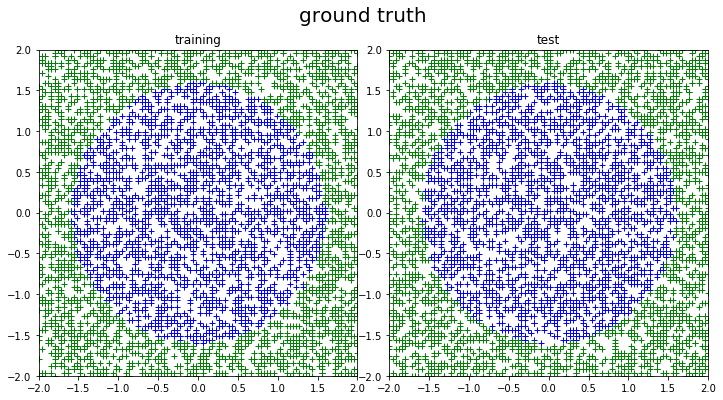

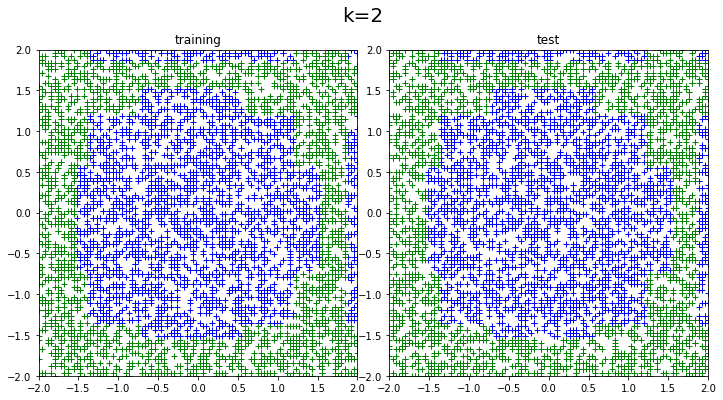

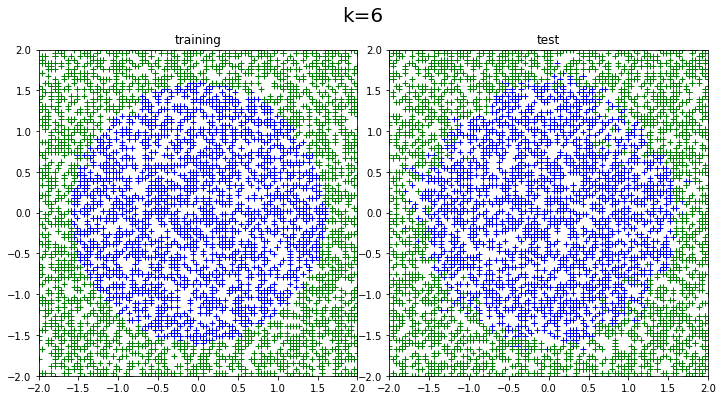

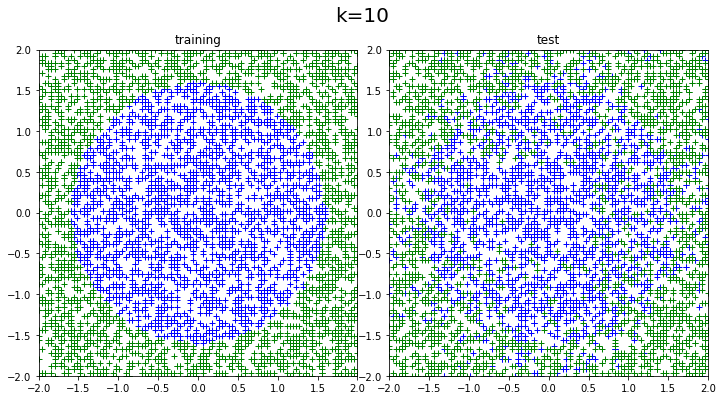

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.1)
fig.suptitle('ground truth', fontsize=20)

plot_circle(X_train, y_train, axs[0], title='training')
plot_circle(X_test, y_test, axs[1], title='test')

for k in k_list:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.subplots_adjust(wspace=0.1)
    fig.suptitle('k={}'.format(k), fontsize=20)

    plot_circle(X_train, train_preds[k], axs[0], title='training')
    plot_circle(X_test, test_preds[k], axs[1], title='test')

# Améliorations

L'objectif de cette amélioration est de ne calculer que les luts utiles pour l'entraînement et la prédictions. Le modèle reste donc inchangé, seul le temps de calcul se trouve amélioré.

In [259]:
class Improved_Memorization(Memorization):
    def __init__(self, layers, k):
        super().__init__(layers, k)
        
        useful = [list(range(layers[-1]))]
        for i in range(len(self.list_luts) - 1, -1, -1):
            x = []
            for j in useful[-1]:
                x += list(self.list_luts[i][j])
            useful.append(sorted(list(set(x))))
        
        self.useful = list(reversed(useful)) # Ensemble des luts dont le calcul est utile, par couche
        
    
    def fit(self, X_train, y_train, print_training_accuracy = False):
        #Display training accuracy for the first layer (layer 0)
        if print_training_accuracy:
                print("Layer = " + str(0) 
                      + " | Lut count = " + (str(self.layers[0]) + "    ")[:5]
                      + " | Useful luts = " + (str(len(self.useful[0])) + "    ")[:5]
                      + " | Training Accuracy = " + str(self.accuracy(X_train, y_train)))
                
        n = len(X_train)
        
        list_computed = [X_train] #initialise la liste des couches qui vont être calculées
        self.list_link = [] # liste des liaisons entre luts

        # Entraînement couche par couche
        for layer in range(1, len(self.layers)): #numero de la couche
            layer_luts = self.list_luts[layer - 1] #liste des luts de la couche précédente et de taille k (combinaison aléatoire)

            last_computed_layer = list_computed[-1] #récupère la dernière couche

            link = []
            next_computed_layer = [[0 for x in range(self.layers[layer])] for y in range(n)] #initialiste la couche suivante 
                                                                                             #(taille de la couche suivant * nombre d'exemples dans le dataset)
            
            for i in range(self.layers[layer]): #parcourt la taille de la couche pour chaque couche
                if i in self.useful[layer]:
                    dict_positif = self.dict.copy() #init du dictionnaire stockant le nombre de valeurs positives
                    dict_negatif = self.dict.copy() #init du dictionnaire stockant le nombre de valeurs négatives

                    for j in range(n): #parcourt le nombre d'exemples dans le dataset
                        s = ""
                        for z in range(self.k): #parcourt la taille k pour chaque exemple
                            try :
                                s += str(last_computed_layer[j][layer_luts[i][z]]) #donne la valeur binaire pour chaque exemple (j) grâce à la combinaison aléatoire des luts de la couche précédente
                            except :
                                print(layer_luts[i][z])
                        next_computed_layer[j][i] = s #stocke la valeur binaire dans la nouvelle couche à la position (j=numero d'exemples, i=numero dans la taille de la couche)
                        dict_negatif[s] += (y_train[j] == 0).astype(int) #stocke dans le dict neg pour la clé binaire, le nombre de valeurs negatives dans le dataset
                        dict_positif[s] += (y_train[j] == 1).astype(int) #stocke dans le dict pos pour la clé binaire, le nombre de valeurs positive dans le dataset

                    dict_ = self.dict.copy()

                    #prédiction finale obtenu par la comparaison du nombre de valeurs positives par rapport aux nombres de valeurs négatives
                    for l in dict_.keys():
                        if dict_positif[l] > dict_negatif[l]:
                            dict_[l] = 1
                        elif dict_positif[l] < dict_negatif[l]:
                            dict_[l] = 0
                        else :
                            dict_[l] = np.random.randint(2)

                    #attribut la valeur finale pour la nouvelle couche à la position j(num exemple pour chaque exemple), i(num taille de la couche)
                    for j in range(n): #reparcourt le nombre d'exemples dans le dataset
                        next_computed_layer[j][i] = dict_[next_computed_layer[j][i]]

                    link.append(dict_) #rajoute le dict des valeurs prédites 'dict_' dans une liste 'link'
                else :
                    link.append(0)

            list_computed.append(next_computed_layer) #rajoute la nouvelle couche dans la liste 'list_computed'
            self.list_link.append(link) #rajoute la liste 'link' dans la liste générale 'list_link'
            
            if print_training_accuracy:
                print("Layer = " + str(layer) 
                      + " | Lut count = " + (str(self.layers[layer]) + "    ")[:5] 
                      + " | Useful luts = " + (str(len(self.useful[layer])) + "    ")[:5]
                      + " | Training Accuracy = " + str(self.accuracy(X_train, y_train)))
                
    """
    Prediction de la classe pour une entrée x.
    """
    def one_prediction(self, x):   
        list_computed = [x]

        # Calcul couche par couche
        for layer in range(len(self.list_link)):
            layer_luts = self.list_luts[layer]
            link = self.list_link[layer]
            last_computed_layer = list_computed[-1]

            next_computed_layer = []
            for i in range(len(layer_luts)):
                
                if i in self.useful[layer +1]:
                    s = ""
                    for z in range(self.k):
                        s += str(last_computed_layer[layer_luts[i][z]])
                    next_computed_layer.append(link[i][s])
                    
                else:
                    next_computed_layer.append(0)
            list_computed.append(next_computed_layer)
        
        # Somme du nombre de 1 sur l'ensemble des luts de la dernière couche
        resu = 0
        for i in range(len(self.list_luts[len(self.list_link) - 1])):
            resu += list_computed[-1][i]
        
        # Retourne 1 si il y a plus de 1 que de 0 sur l'ensemble des luts de la dernière couche (0 sinon)
        return int(resu > len(self.useful[len(self.list_link)]) / 2)

In [260]:
layers = [784, 1024, 1024, 1024, 1024, 1024, 1] 
k = 8

In [262]:
model.fit(X_train, y_train, print_training_accuracy = True)

Layer = 0 | Lut count = 784   | Useful luts = 784   | Training Accuracy = 0.486
Layer = 1 | Lut count = 1024  | Useful luts = 1024  | Training Accuracy = 0.825
Layer = 2 | Lut count = 1024  | Useful luts = 985   | Training Accuracy = 0.948
Layer = 3 | Lut count = 1024  | Useful luts = 418   | Training Accuracy = 0.985
Layer = 4 | Lut count = 1024  | Useful luts = 64    | Training Accuracy = 0.998
Layer = 5 | Lut count = 1024  | Useful luts = 8     | Training Accuracy = 0.999
Layer = 6 | Lut count = 1     | Useful luts = 1     | Training Accuracy = 1.0


NB : Pour cet entraînement, seul une partie du jeu d'entraînement a été utilisé, par manque de temps. Ce qui explique la différence notable d'accuracy avec l'expérience 1.